# HMM in Pytorch

Because the HMM forward algorithm is differentiable with respect to all the model parameters, we can also just take advantage of automatic differentiation methods in libraries like PyTorch and try to minimize $-\text{log }p_{\theta}(\mathbf{x})$ directly, by backpropagating through the forward algorithm and running stochastic gradient descent. That means we don't need to write any additional HMM code to implement training: `loss.backward()` is all you need.

Ideas taken from [this notebook](https://colab.research.google.com/drive/1IUe9lfoIiQsL49atSOgxnCmMR_zJazKI#scrollTo=qeDG8DVmZ-P0).

For a high level usage of HMMs, see [hmmlearn](https://hmmlearn.readthedocs.io/en/latest/#).

In [11]:
# Import Required Libraries
import numpy as np
import torch
import torch.distributions as dist
import torch.nn as nn
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Text(0.5, 1.0, 'Time Series of Observations')

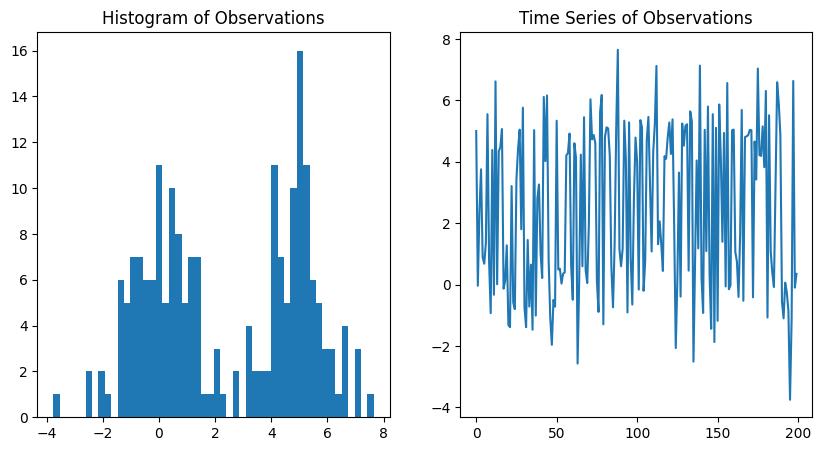

In [12]:
# Generate some observations with two normal distributions randomly mixed
observations = np.concatenate([np.random.normal(0, 1, 100), np.random.normal(5, 1, 100)])
np.random.shuffle(observations)

# Plot histogram and time series
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].hist(observations, bins=50)
ax[0].set_title('Histogram of Observations')
ax[1].plot(observations)
ax[1].set_title('Time Series of Observations')

In [3]:
# Define the Hidden Markov Model
class HMM(nn.Module):
    def __init__(self, num_states, num_observations):
        super(HMM, self).__init__()
        self.num_states = num_states
        self.num_observations = num_observations

        # Initialize the model parameters
        self.start_prob = torch.nn.Parameter(torch.randn(num_states))
        self.transition_prob = torch.nn.Parameter(torch.randn(num_states, num_states))
        self.emission_mean = torch.nn.Parameter(torch.randn(num_states, num_observations))
        self.emission_stddev = torch.nn.Parameter(torch.randn(num_states, num_observations))

    def forward(self, observations):
        # Compute the log probabilities of the first observation
        log_prob = dist.Normal(self.emission_mean, torch.exp(self.emission_stddev)).log_prob(observations[0])
        log_prob += self.start_prob.view(-1, 1)

        # Compute the log probabilities of the remaining observations
        for observation in observations[1:]:
            emission_log_prob = dist.Normal(self.emission_mean, torch.exp(self.emission_stddev)).log_prob(observation)
            transition_log_prob = self.transition_prob.t()
            log_prob = self.log_sum_exp(transition_log_prob + log_prob.unsqueeze(-1) + emission_log_prob)

        return -self.log_sum_exp(log_prob)

    @staticmethod
    def log_sum_exp(tensor):
        max_val = tensor.max()
        return max_val + (tensor - max_val).exp().sum().log()

In [4]:
# Initialize the model
model = HMM(num_states=2, num_observations=1)
model.to(device)

# Define the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# Train the model
for i in range(1000):
    optimizer.zero_grad()
    loss = model(observations)
    loss.backward()
    optimizer.step()
    if i % 100 == 0:
        print(f"Loss: {loss.item()}")

# Print the model parameters
print(f"Start Probabilities: {model.start_prob}")
print(f"Transition Probabilities: {model.transition_prob}")
print(f"Emission Mean: {model.emission_mean}")
print(f"Emission Stddev: {model.emission_stddev}")

# Print the log probability of the observations
print(f"Log Probability of Observations: {model(observations)}")

/home/victor/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loss: 2588.433349609375
Loss: -37779.23046875
Loss: -77173.859375
Loss: -116966.3515625
Loss: -157204.5
Loss: -196179.453125
Loss: -235412.953125
Loss: -275688.53125
Loss: -315340.71875
Loss: -354730.65625
Start Probabilities: Parameter containing:
tensor([0.4694, 8.4745], requires_grad=True)
Transition Probabilities: Parameter containing:
tensor([[ 9.9222e-01, -1.5437e+00],
        [ 1.9615e+00,  1.9867e+03]], requires_grad=True)
Emission Mean: Parameter containing:
tensor([[11.0494],
        [ 2.3916]], requires_grad=True)
Emission Stddev: Parameter containing:
tensor([[49.2144],
        [ 7.9467]], requires_grad=True)
Log Probability of Observations: -393586.3125


## Add the Viterbi algorithm

The Viterbi algorithm is used to find the most likely sequence of hidden states given a sequence of observations. Here's how you can add it to your HMM class:

In [19]:
def viterbi(self, observations):
        # Batch size is 1 for simplicity
        T_max = observations.size(0)
        log_delta = torch.zeros(T_max, self.num_states).to(observations.device)
        psi = torch.zeros(T_max, self.num_states).long().to(observations.device)

        # Initialization
        log_state_priors = torch.nn.functional.log_softmax(self.start_prob, dim=0)
        log_delta[0, :] = self.emission_log_prob(observations[0]) + log_state_priors

        # Recursion
        for t in range(1, T_max):
            max_val, argmax_val = self.transition_model_maxmul(log_delta[t-1, :])
            log_delta[t, :] = self.emission_log_prob(observations[t]) + max_val
            psi[t, :] = argmax_val

        # Backtrack
        z_star = [log_delta[T_max - 1, :].argmax().item()]
        for t in range(T_max - 1, 0, -1):
            z_star.insert(0, psi[t, z_star[0]].item())

        return z_star

def emission_log_prob(self, observation):
        # Compute log probability of emission
        return dist.Normal(self.emission_mean, torch.exp(self.emission_stddev)).log_prob(observation).sum(dim=1)

def transition_model_maxmul(self, log_alpha):
        # Log domain max-multiplication (Viterbi update step)
        log_transition_matrix = torch.nn.functional.log_softmax(self.transition_prob, dim=1)
        max_val, argmax_val = torch.max(log_transition_matrix + log_alpha.unsqueeze(-1), dim=0)
        return max_val, argmax_val

HMM.viterbi = viterbi 
HMM.emission_log_prob = emission_log_prob  
HMM.transition_model_maxmul = transition_model_maxmul 

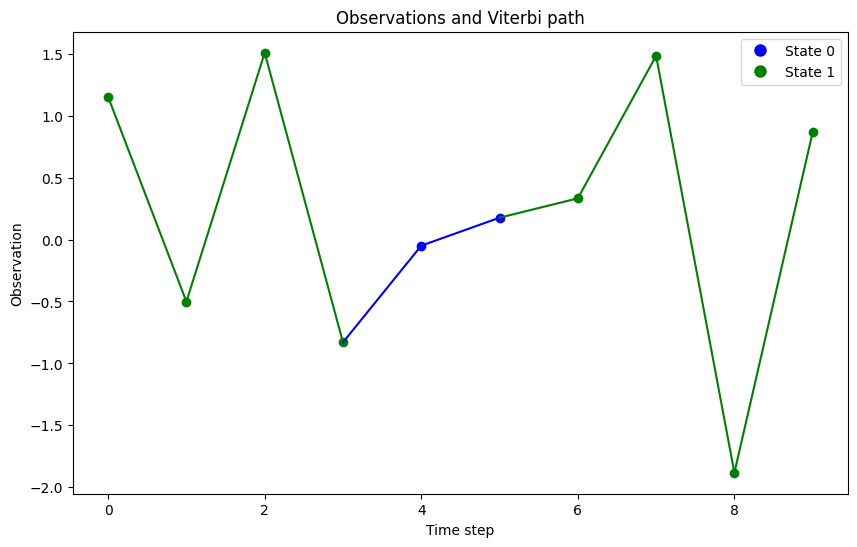

In [28]:
from matplotlib.lines import Line2D

fig, ax = plt.subplots(figsize=(10, 6))

# Plot the observations with the color representing the state
colors = ['blue', 'green']  # Add more colors if you have more states
for i in range(len(path)):
    ax.scatter(i, observations[i].cpu().numpy(), color=colors[path[i]])
    # link the observations with lines
    if i > 0:
        ax.plot([i-1, i], [observations[i-1].cpu().numpy(), observations[i].cpu().numpy()], color=colors[path[i]])

# Create a list of Line2D objects to represent each state in the legend
legend_elements = [Line2D([0], [0], marker='o', color='w', label='State {}'.format(i), markerfacecolor=c, markersize=10) for i, c in enumerate(colors)]

# Add the legend to the plot
ax.legend(handles=legend_elements, loc='upper right')

ax.set_xlabel('Time step')
ax.set_ylabel('Observation')

plt.title('Observations and Viterbi path')
plt.show()

## Model selection with Bayesian Information Criterion (BIC)

TODO by students

The Bayesian Information Criterion (BIC) is a criterion for model selection among a finite set of models; it is based on the likelihood function and takes into consideration the number of parameters in the model. It is particularly useful in scenarios like selecting the best Hidden Markov Model (HMM) from a set of HMMs that differ in the number of states or in the structure of the transition matrix.

The formula for BIC is given by:

\[ \text{BIC} = -2 \cdot \ln(\hat{L}) + k \cdot \ln(n) \]

where:
- \(\hat{L}\) is the maximized value of the likelihood function of the model. For HMMs, this is typically obtained using algorithms like the Baum-Welch algorithm, which finds the set of model parameters that maximizes the likelihood of the observed sequence of emissions.
- \(k\) is the number of free parameters to be estimated. In the context of HMMs, this includes the parameters of the emission probability distributions, the initial state distribution, and the state transition probabilities.
- \(n\) is the number of data points, which, for HMMs, would be the length of the observed sequence of emissions. If the model is fitted on multiple sequences, n would be the sum of the lengths of all sequences.

The BIC penalizes complex models, which is reflected by the term involving the number of parameters \(k\). The idea is to balance model complexity with goodness of fit. Lower values of BIC indicate a better model, taking into consideration both the likelihood and the number of parameters. When selecting among multiple HMMs, the one with the lowest BIC is generally preferred as it suggests the model is more likely to be the true generator of the observed data, without being unnecessarily complex.





